# Atari Pong

## Import

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import gym
import os
import datetime
import imageio
import numpy as np
import argparse
import pickle
import shutil
import cv2
import random

from collections import deque
from IPython.core.debugger import set_trace

## Class
- ObWrapper as env support
  - ob->state
  - function:
    - wrapper_append(ob)
    - wrapper_len()
    - wrapper_packup()
- Replay
  - sample memory for train
  - function:
    - mome_append(a_set_memory)
    - sample()
- CNN
  - create a cnn refer to dqn paper
- Agent 
  - Replay
  - CNN

### ObWrapper Class

In [2]:
# make sure import deque from collections 
# and opencv(cv2)
# and numpy as np
class ObWrapper:
    def __init__(self, WRAPPER_SIZE = 4 ):
        self.WRAPPER_SIZE = WRAPPER_SIZE
        self.s = deque([],maxlen = WRAPPER_SIZE) #wrapper how many frame together
        
    def __call__(self,ob):
        self.s.append(cv2.cvtColor(ob,cv2.COLOR_BGR2GRAY)[::2,::2][17:97,:])
   
    def __len__(self):
        return len(self.s)
    
    def packup(self):
        if len(self.s) < self.WRAPPER_SIZE:
            return print("Wrapper too small, unpackable")
        a = np.array([self.s[i] for i in range(self.WRAPPER_SIZE)])
        b = np.transpose(a,(1,2,0))  # or b = np.einsum('ijk->jki',a)
        return b.reshape(-1,80,80,self.WRAPPER_SIZE)

### Replay Class

In [3]:
# make sure import random
# and deque from collections
class Replay:
    def __init__(self, MEMORY_SIZE = 50_000, BATCH_SIZE = 64):
        self.BATCH_SIZE = BATCH_SIZE
        self.MEMORY_SIZE = MEMORY_SIZE
        self.memory = deque([],maxlen = MEMORY_SIZE)
        
    def memo_append(self, a_set_memory):
        # a_set_memory = sars(a) : [ob, (act), reward, ob_next, done]
        self.memory.append(a_set_memory)

    def memo_len(self):
        return len(self.memory)
        
    def sample(self):
        return random.sample(self.memory,self.BATCH_SIZE)

### CNN Class

In [4]:
# import tensorflow as tf
# import numpy as np
class CNN:
    def __init__(self,N_ACT, N_OB,\
                 WRAPPER_SIZE = 4,\
                 LEARNING_RATE = 0.01):
        # N_OB: frame for weight, height, color_channel
        # -> backup to n frame : weight, height, WRAPPER_SIZE
        
        self.INPUT_SIZE  = self.input_size([80,80], WRAPPER_SIZE)
        self.OUTPUT_SIZE = N_ACT
        self.LEARNING_RATE = LEARNING_RATE
        self.model = self.create_cnn()
        
    def input_size(self,N_OB, WRAPPER_SIZE):
        return (N_OB[0],N_OB[1],WRAPPER_SIZE)
    
    def create_cnn(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16,8,strides = 4,input_shape =self.INPUT_SIZE,\
                                   activation = 'relu'),
            tf.keras.layers.Conv2D(32,4,strides = 2, activation = 'relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256,               activation = 'relu'),
            tf.keras.layers.Dense(self.OUTPUT_SIZE, activation = 'linear'),
        ])
        model.compile(
            loss = 'huber_loss',
            optimizer = tf.keras.optimizers.Adam(learning_rate=self.LEARNING_RATE),
            metrics   = ['accuracy']
        )
        return model

### Agent

In [5]:
class Agent(Replay,CNN):
    def __init__(self, N_ACT,N_OB,\
                 GAMMA = 0.9, EPSILON = 0.3, EPSILON_DECAY = 0.997,\
                 MODEL_UPDATE_STEP = 2000, MEMORY_SAMPLE_START = 0.2,\
                 LEARNING_RATE = 0.01,\
                 MEMORY_SIZE = 50_000,BATCH_SIZE = 64,\
                 WRAPPER_SIZE = 4\
                 ):
        Replay.__init__(self,     MEMORY_SIZE = MEMORY_SIZE,\
                                   BATCH_SIZE = BATCH_SIZE)
        
        CNN.__init__(self, N_ACT, N_OB,\
                      WRAPPER_SIZE = WRAPPER_SIZE,\
                     LEARNING_RATE = LEARNING_RATE)

        self.N_ACT   = N_ACT
        self.GAMMA   = GAMMA
        self.EPSILON = EPSILON
        self.EPSILON_DECAY = EPSILON_DECAY

        self.target_model = self.create_cnn()
        self.target_model.set_weights(self.model.get_weights())
        self.MODEL_UPDATE_STEP = MODEL_UPDATE_STEP
        self.STEP = 0
        
        self.MEMORY_SAMPLE_START = MEMORY_SAMPLE_START
        
    
    def get_q_value(self, state):
        # state is obwrapper.packup
        
        q = self.model.predict(state.packup())
        return q
    
    
    def get_action(self,state): # get action with epsilon greedy
        if np.random.rand() < self.EPSILON:
            return np.random.randint(self.N_ACT)
        return np.argmax(self.get_q_value(state))
    
    
    def train(self): 
        #if the momery len > 0.2 memory size
        if self.memo_len() < self.MEMORY_SIZE * self.MEMORY_SAMPLE_START:
            return
        batch_memo = self.sample()
        
        # model for q now
        batch_state = np.array([ a_set_memo[0][0,:,:,:] for a_set_memo in batch_memo])
        batch_q     = self.model.predict(batch_state)
        
        # target_model for max q
        batch_state_next = np.array([ a_set_memo[3][0,:,:,:] for a_set_memo in batch_memo])
        batch_q_next = self.target_model.predict(batch_state_next)
        
        batch_q_new = []
        for index,(state, action, reward, state_next, done) in enumerate(batch_memo):
            if done:
                q_new = reward
            else:
                q_new = reward + self.GAMMA * max(batch_q_next[index])
 
            q = batch_q[index]
            q[action] = q_new
            batch_q_new.append(q)
            
        self.STEP +=1
        self.model.fit(batch_state,np.array(batch_q_new),batch_size = self.BATCH_SIZE, verbose = 0)
        
    def target_model_update(self):
        if self.STEP < self.MODEL_UPDATE_STEP:
            return
        self.STEP = 0
        self.target_model.set_weights(self.model.get_weights())

## GIF handel

In [6]:
def gif_save(DIR_PNG,ep,ave_reward):
    # make gif
    images = []
    for f in os.listdir(DIR_PNG):
        images.append(imageio.imread(os.path.join(DIR_PNG,f)))
    imageio.mimsave(os.path.join(DIR,str(ep)+'_r_'+str(ave_reward)+'.gif'),images)
    shutil.rmtree(DIR_PNG)

In [7]:
def png_save(DIR_PNG,env,step):
    plt.imsave(os.path.join(DIR_PNG,str(step)+'.png'),env.render(mode='rgb_array'))

## Train The Model        

In [9]:
class Args:
    EPOCHS   = 2
    
    GAMMA    = 0.9
    EPSILON  = 0.3
    EPSILON_DECAY  = 0.9997
    
    LEARNING_RATE = 0.01
    
    BATCH_SIZE  = 64
    MEMORY_SIZE = 5_00

    MODEL_UPDATE_STEP   = 2000
    MEMORY_SAMPLE_START = 0.2
    
    WRAPPER_SIZE = 4

In [10]:
args = Args
EPOCHS = args.EPOCHS

GAMMA   = args.GAMMA
EPSILON = args.EPSILON
EPSILON_DECAY = args.EPSILON_DECAY

LEARNING_RATE = args.LEARNING_RATE

BATCH_SIZE = args.BATCH_SIZE
MEMORY_SIZE = args.MEMORY_SIZE

MODEL_UPDATE_STEP = args.MODEL_UPDATE_STEP

MEMORY_SAMPLE_START = args.MEMORY_SAMPLE_START

WRAPPER_SIZE = args.WRAPPER_SIZE


In [11]:
env_name = 'Pong-v0'
env = gym.make(env_name)

N_ACT = env.action_space.n
N_OB  = env.observation_space.shape

In [12]:
print(env.unwrapped.get_action_meanings())

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [13]:
agent = Agent(N_ACT,N_OB,\
             GAMMA = GAMMA, EPSILON = EPSILON, EPSILON_DECAY = EPSILON_DECAY, \
             MODEL_UPDATE_STEP   = MODEL_UPDATE_STEP,   \
             MEMORY_SAMPLE_START = MEMORY_SAMPLE_START, \
             LEARNING_RATE = LEARNING_RATE, \
             MEMORY_SIZE   = MEMORY_SIZE,   \
             BATCH_SIZE    = BATCH_SIZE,    \
             WRAPPER_SIZE  = WRAPPER_SIZE \
             )

### Main

In [18]:
reward_summary = {
    'max':[],
    'min':[],
    'ave':[],
    'sum':[]
}

ROOT_DIR = 'test_DQN'
DIR = os.path.join(ROOT_DIR,datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
try:
    os.makedirs(DIR)
except:
    pass

log_file = open(DIR+'/log.txt','w')

state      = ObWrapper(WRAPPER_SIZE=WRAPPER_SIZE)
state_next = ObWrapper(WRAPPER_SIZE=WRAPPER_SIZE)

ob = env.reset()
state_next(ob)
while (len(state_next) is not WRAPPER_SIZE):
    state(ob)
    state_next(ob)

DIR_PNG = os.path.join(DIR,"temp_png")

In [19]:
# =========================================================
for ep in range(EPOCHS):
    
    
    os.mkdir(DIR_PNG) 
    
    reward_list = []
    step = 0
    ob = env.reset()
    agent.EPSILON *=agent.EPSILON_DECAY
    
    #======================================================
    while(1):
        png_save(DIR_PNG,env,step)
        set_trace()
        state(ob)
        act = agent.get_action(state)
        
        ob_next, reward, done, info = env.step(act)
        
        #reward = 10 if reward else -1
        state_next(ob_next)
        
        agent.memo_append([state.packup(), act, reward, state_next.packup(), done])
        agent.train()
        agent.target_model_update()

        ob = ob_next
        step += 1
        reward_list.append(reward)
        
        if done:
            out = "Epoch {} - average rewards {} with step {}".format(ep,sum(reward_list)/len(reward_list),step)
            print(out)
            log_file.write(out+"\n")
            reward_summary['max'].append(max(reward_list))
            reward_summary['min'].append(min(reward_list))
            reward_summary['sum'].append(sum(reward_list))
            reward_summary['ave'].append(sum(reward_list)/len(reward_list))
            break

    gif_save(DIR_PNG,ep,sum(reward_list)/len(reward_list))

> <ipython-input-19-c34526c0e11a>(17)<module>()
     15         png_save(DIR_PNG,env,step)
     16         set_trace()
---> 17         state(ob)
     18         act = agent.get_action(state)
     19 



ipdb>  c


> <ipython-input-19-c34526c0e11a>(16)<module>()
     14     while(1):
     15         png_save(DIR_PNG,env,step)
---> 16         set_trace()
     17         state(ob)
     18         act = agent.get_action(state)



ipdb>  c


> <ipython-input-19-c34526c0e11a>(17)<module>()
     15         png_save(DIR_PNG,env,step)
     16         set_trace()
---> 17         state(ob)
     18         act = agent.get_action(state)
     19 



ipdb>  c


> <ipython-input-19-c34526c0e11a>(16)<module>()
     14     while(1):
     15         png_save(DIR_PNG,env,step)
---> 16         set_trace()
     17         state(ob)
     18         act = agent.get_action(state)



ipdb>  c


> <ipython-input-19-c34526c0e11a>(17)<module>()
     15         png_save(DIR_PNG,env,step)
     16         set_trace()
---> 17         state(ob)
     18         act = agent.get_action(state)
     19 



ipdb>  c


> <ipython-input-19-c34526c0e11a>(16)<module>()
     14     while(1):
     15         png_save(DIR_PNG,env,step)
---> 16         set_trace()
     17         state(ob)
     18         act = agent.get_action(state)



ipdb>  c


> <ipython-input-19-c34526c0e11a>(17)<module>()
     15         png_save(DIR_PNG,env,step)
     16         set_trace()
---> 17         state(ob)
     18         act = agent.get_action(state)
     19 



ipdb>  c


> <ipython-input-19-c34526c0e11a>(16)<module>()
     14     while(1):
     15         png_save(DIR_PNG,env,step)
---> 16         set_trace()
     17         state(ob)
     18         act = agent.get_action(state)



ipdb>  c


> <ipython-input-19-c34526c0e11a>(17)<module>()
     15         png_save(DIR_PNG,env,step)
     16         set_trace()
---> 17         state(ob)
     18         act = agent.get_action(state)
     19 



ipdb>  c


> <ipython-input-19-c34526c0e11a>(16)<module>()
     14     while(1):
     15         png_save(DIR_PNG,env,step)
---> 16         set_trace()
     17         state(ob)
     18         act = agent.get_action(state)



ipdb>  c


> <ipython-input-19-c34526c0e11a>(17)<module>()
     15         png_save(DIR_PNG,env,step)
     16         set_trace()
---> 17         state(ob)
     18         act = agent.get_action(state)
     19 



ipdb>  c


> <ipython-input-19-c34526c0e11a>(16)<module>()
     14     while(1):
     15         png_save(DIR_PNG,env,step)
---> 16         set_trace()
     17         state(ob)
     18         act = agent.get_action(state)



ipdb>  c


> <ipython-input-19-c34526c0e11a>(17)<module>()
     15         png_save(DIR_PNG,env,step)
     16         set_trace()
---> 17         state(ob)
     18         act = agent.get_action(state)
     19 



ipdb>  q


BdbQuit: 

Show the reward every ep


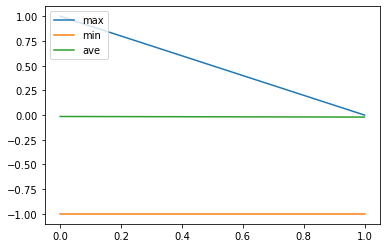

In [15]:
log_file.close()
#=============== Show the reward every ep
print('Show the reward every ep')
plt.figure()
plt.plot(reward_summary['max'],label='max')
plt.plot(reward_summary['min'],label='min')
plt.plot(reward_summary['ave'],label='ave')
plt.legend(loc=2)
plt.savefig(DIR + '/rewards.png')

reward_summary = {[max],[min],[ave]}

for ep:

    ob = env.reset()
    
    reward = []
    save the gif
    while(done):
        env.reder() 
            - save png
        act = get_action(ob)
            
        state<-ob
        
        ob_next, reward, done ,info = env.step(act)
            reward = big if reward else -1
            
        state_next<-ob_next
        
        #=========
        if state.len>3:
            a-set-memory = [state,packup,(act),reward, state_next,done]
            memo_append(a-set-memory)
            train()
            target_update()
        #=========
        
        ob = ob_next
        
        reward_list.append(reward)
        
        if done:
            print(step,reward)
            log.write()
            break
            
    reward_summary[max][min][ave][sum]<-reward_list
    build_gif(ep)
    

### Final Run for Test

In [16]:
# print(state.packup().shape,state.s[0].shape[0],state.s[0].shape[0],WRAPPER_SIZE)

In [17]:
print('Test the final round')
# observe the final run

DIR_FINAL = os.path.join(DIR,'final')
try:
    os.mkdir(DIR_FINAL)
except:
    pass

log_file = open(DIR+'/log.txt','a')

ob = env.reset()
reward_list = []
step = 0

state      = ObWrapper(WRAPPER_SIZE=WRAPPER_SIZE)
state_next = ObWrapper(WRAPPER_SIZE=WRAPPER_SIZE)
state_next(ob)

while (len(state_next) is not WRAPPER_SIZE):
    state(ob)
    state_next(ob)
    
ob, reward, done, info = env.step(1)
while(1):
    png_save(DIR_FINAL,env,step)
    state(ob)
    
    act = np.argmax(agent.get_q_value(state))

    ob_next,reward,done,info = env.step(act)
    state_next(ob_next)
    
    reward_list.append(reward)
    step +=1
    ob = ob_next
    
    if done:
        out = 'Final: ave rewards - {}, step - {}\n'.format(sum(reward_list)/len(reward_list),step)
        log_file.writelines(out)
        print(out)
        break
        
gif_save(DIR_FINAL,'final',sum(reward_list)/len(reward_list))
       
log_file.close()
env.close()
print("Done")

Test the final round
Final: ave rewards - -0.020771513353115726, step - 1011

Done


## Try thins here

### Try for ObWrapper

In [ ]:
print(type(ob))
a.wrapper_append(ob)
print(a.wrapper_len())

In [ ]:
print(a.s[0].shape)
plt.imshow(a.s[0])
plt.show()

### Class seperately

In [ ]:
# make sure import deque from collections 
# and opencv(cv2)
# and numpy as np
class ObWrapper:
    def __init__(self, WRAPPER_SIZE = 4):
        self.WRAPPER_SIZE = WRAPPER_SIZE
        self.s = deque([],maxlen = WRAPPER_SIZE) #wrapper how many frame together
    def __call__(self,ob):
        self.s.append((cv2.cvtColor(ob,cv2.COLOR_BGR2GRAY))[::2,::2][17:97,:])
    def __len__(self):
        return len(self.s)
    def packup(self):
        a = np.array([self.s[i] for i in range(self.WRAPPER_SIZE)])
        b = np.transpose(a,(1,2,0))  # or b = np.einsum('ijk->jki',a)
        return b

In [ ]:
# make sure import random
# and deque from collections
class Replay:
    def __init__(self, MEMORY_SIZE = 5_000, BATCH_SIZE = 64):
        self.BATCH_SIZE = BATCH_SIZE
        self.memory = deque([],maxlen = MEMORY_SIZE)
    def __call__(self, a_set_memory):
        # a_set_memory = sars(a) : [ob, act, reward, ob_next, done]
        self.memory.append(a_set_memory)
    def sample(self,*args):
        if args:
            b_size = args[0]
        else:
            b_size = self.BATCH_SIZE
        return random.sample(self.memory,b_size)

### Try image resize and 4 frame for input

In [ ]:
DIR = 'gif'
try:
    os.mkdir(DIR)
except:
    pass

In [ ]:
ob = env.reset()
state = ObWrapper()
state_next = ObWrapper()
state_next(ob)
for i in range(5):
    plt.imsave(os.path.join(DIR,str(i)+'.png'),env.render(mode='rgb_array'))
    act = env.action_space.sample()
    state(ob)
    
    ob_next,reward, done, info = env.step(act)
    state_next(ob_next)
    ob = ob_next

In [ ]:
print(len(state))
print(len(state_next))

print(np.array_equal(state.s[1],state_next.s[0]))
print(np.array_equal(state.s[2],state_next.s[1]))
print(np.array_equal(state.s[3],state_next.s[2]))

print(state.s[0].shape)

In [ ]:
plt.subplot(131)
plt.imshow(state.s[1],cmap = 'gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(state.s[2],cmap = 'gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(state.s[3],cmap = 'gray')
plt.axis('off')
plt.show()

plt.subplot(131)
plt.imshow(state_next.s[0],cmap = 'gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(state_next.s[1],cmap = 'gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(state_next.s[2],cmap = 'gray')
plt.axis('off')
plt.show()

### Try GIF display in jupyter

In [ ]:
DIR = 'gif'
os.mkdir(DIR)

In [ ]:
ob = env.reset()

for i in range(20):
    plt.imsave(os.path.join(DIR,str(i)+'.png'),env.render(mode='rgb_array'))
    env.step(env.action_space.sample())

images = []
for f in os.listdir(DIR):
    images.append(imageio.imread(os.path.join(DIR,f)))
imageio.mimsave(os.path.join(DIR,'test.gif'),images)

In [ ]:
from IPython.display import Image
Image(os.path.join(DIR,'test.gif'))

In [ ]:
a = [84,84]
print(tuple(a))

In [ ]:
print(cv2.resize(cv2.cvtColor(ob,cv2.COLOR_BGR2GRAY),tuple(a)).shape)
plt.imshow(cv2.cvtColor(ob,cv2.COLOR_BGR2GRAY),cmap="gray")
plt.show()
plt.imshow(cv2.resize(cv2.cvtColor(ob,cv2.COLOR_BGR2GRAY),tuple(a)),cmap="gray")
plt.show()